# Synthetic Image Generation using Deep Convoluted Generative Adverserial Network #

In reference to "Generative Adverserial Network"(2015) by Ian Goodfellow, GAN or Generative Adverserial Network is a Machine Learning model where two neural networks are competiting with each other in a max-min strategy. The Deep Convoluted Generative Adverserial Network(DCGAN) is an improvement over the conventional GAN with some Convolutional Neural Network(CNN) layers added to it. 

The main aim of this project is to generate images of fashion items using Machine Learning model. If you want to know more about the working of the model kindly visit <a href = "www.abcd.com"> </a>

The image below is a gif showing a rough overview of the image present in fashion MNIST.

![](/images/dc_gan.gif)

The packages used in the repository are:-

 1. tensorflow 
 2. numpy
 3. plot_utils
 4. matplotlib
 5. tqdm
 6. IPython
 


In [24]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
from plot_utils import show
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


## Loading and Processing the Data ##

The fashion MNIST data is already present in the tensorflow.



In [25]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

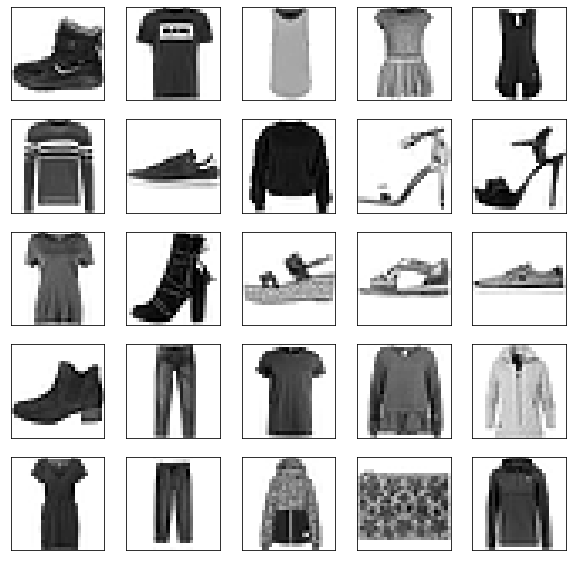

In [26]:
plt.figure(figsize = (10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[i], cmap = plt.cm.binary)
plt.show()

In [27]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

## Generator Network for DCGAN ##

![gan_framework.png](/image/gan_framework.png)

There are two neural networks responsible, Generative Network and Discriminative Network. In this the Generative Network is defined. As in the figure above the Generative Network is responsible for making the task of prediction for the Discriminative Network a tough choice. 

The Generative Network is made with fractional-strided convolution layers.  SeLU is being used instead of ReLU and LeakyReLU.

In [28]:
num_features = 100

generator = keras.models.Sequential([ keras.layers.Dense(7 * 7 * 128, input_shape = [num_features]),
                                     keras.layers.Reshape([7, 7, 128]),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding = 'same', activation = 'selu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding = 'same', activation = 'tanh')
])

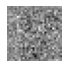

In [29]:
noise = tf.random.normal(shape = [1, num_features])
generated_image = generator(noise, training = False)
show(generated_image, 1)

## Discriminator Network for DCGAN##

The work of a Discriminator Network is to classify the if it belongs to the set of original data or it is a fake data generated by the Generator

In [30]:
discriminator = keras.models.Sequential([
        keras.layers.Conv2D(64, (5,5), (2,2), padding = 'same', input_shape = [28, 28, 1]),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Dropout(0.3),
        keras.layers.Conv2D(128, (5,5), (2,2), padding = 'same'),
        keras.layers.LeakyReLU(0.2),
        keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation = 'sigmoid')
])

In [31]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.4989877]], shape=(1, 1), dtype=float32)


In [32]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False
GAN = keras.models.Sequential([generator, discriminator])
GAN.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

## Training the DCGAN with the Generative and Discriminative models ##

The Generator and Discriminator are trained simoultaeneouly through batches.
The Generator is trained to generate data in order to fool the Discriminator and inturn the discriminator is trained to classify the data as real or fake. 

In [33]:
seed = tf.random.normal(shape = [batch_size, 100])

In [34]:
def train_DCGAN(GAN, dataset, batch_size, num_features, epochs = 5):
  generator, discriminator = GAN.layers
  for epoch in range(epochs):
    print("Epochs {}/{}".format(epoch, epochs))
    for x_batch in dataset:
      noise = tf.random.normal(shape = [batch_size, num_features])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, x_batch], axis = 0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      GAN.train_on_batch(noise, y2)
    display.clear_output(wait = True)
    generate_and_save_images(generator, epoch + 1, seed)
  display.clear_output(wait = True)
  generate_and_save_images(generator, epochs, seed)

In [35]:
def generate_and_save_images(model, epoch, test_input):
  prediction = model(test_input, training = False)
  fig = plt.figure(figsize = (10, 10))

  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5, cmap = 'binary')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [36]:
X_train_DCGAN = X_train.reshape(-1, 28, 28, 1) * 2. -1

In [37]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_DCGAN).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

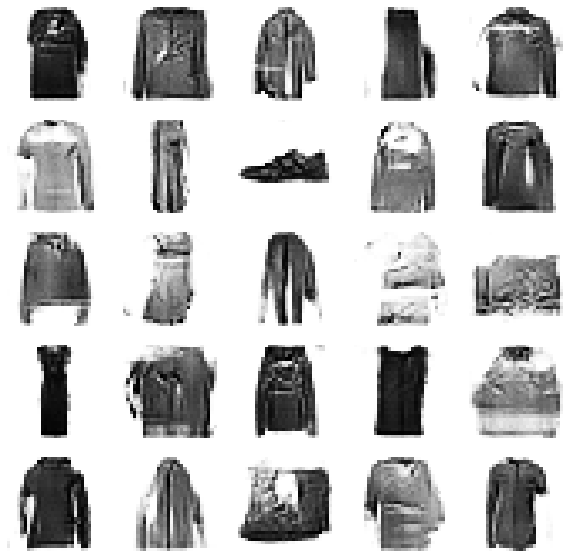

CPU times: user 5min 38s, sys: 19 s, total: 5min 57s
Wall time: 6min 25s


In [22]:
%%time
train_DCGAN(GAN, dataset, batch_size, num_features, epochs = 10)

## Generating Synthetic image using the trained model ##

The Generator is used to generate real-like images which are similar to the initial dataset. The images that are generated in each epoch are mentioned in the README.md file and there is a clear difference in the image generated with passing of each epochs. 

The image quality is comparatively good as compared to the images in MNIST training set.

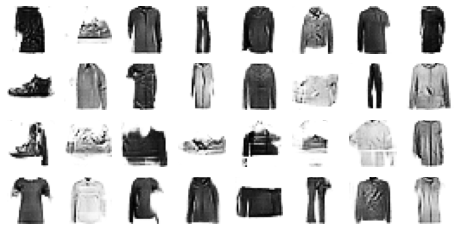

In [23]:
noise = tf.random.normal(shape = [batch_size, num_features])
generated_images = generator(noise)
plot_utils.show(generated_images, 8)